# Run the model for Block 34

In [ ]:
! sudo apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

#For python users, you should also install pyspark using the following command.

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import findspark
findspark.init()

In [ ]:
from google.colab import files
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit,to_date ,hour ,minute ,countDistinct
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
from scipy.optimize import differential_evolution

In [ ]:
sc =SparkSession.builder.master("local").getOrCreate()

In [ ]:
df1 = sc.read.csv('/content/drive/MyDrive/block_0.csv' , inferSchema = True ,header = True)

In [ ]:
df1 = df1.withColumnRenamed("energy(kWh/hh)","energy")

In [ ]:
df1 = df1.withColumn("energy",df1["energy"].cast("float"))

In [ ]:
df1 = df1.filter("energy > 0")

In [ ]:
df1 = df1.na.drop()

In [ ]:
df1 = df1.withColumn('date' ,to_date('tstp'))

In [ ]:
df1 = df1.withColumn('hour' ,hour('tstp'))

In [ ]:
df1 = df1.withColumn("minute", minute(col("tstp")))

In [ ]:
df1 = df1.filter("minute == 0")

In [ ]:
df1.show(1)

+---------+--------------------+------+----------+----+------+
|    LCLid|                tstp|energy|      date|hour|minute|
+---------+--------------------+------+----------+----+------+
|MAC000002|2012-10-12 12:00:...| 0.663|2012-10-12|  12|     0|
+---------+--------------------+------+----------+----+------+
only showing top 1 row



In [ ]:
df1.dtypes

[('LCLid', 'string'),
 ('tstp', 'string'),
 ('energy', 'float'),
 ('date', 'date'),
 ('hour', 'int'),
 ('minute', 'int')]

In [ ]:
df2 = df1.groupby(['hour','date']).sum()

In [ ]:
columns = ['sum(hour)','sum(minute)']
for c in columns:
  df2 = df2.drop(c)

In [ ]:
df2.show(1)

+----+----------+------------------+
|hour|      date|       sum(energy)|
+----+----------+------------------+
|   3|2012-10-26|10.381000064313412|
+----+----------+------------------+
only showing top 1 row



In [ ]:
df_temp = df1.select(['date','LCLid','hour'])

In [ ]:

df_temp1 = df_temp.groupBy(["date",'hour']).agg(countDistinct("LCLid"))

In [ ]:
df_temp1.show(2)

+----------+----+------------+
|      date|hour|count(LCLid)|
+----------+----+------------+
|2013-10-31|  13|          45|
|2013-03-20|   9|          48|
+----------+----+------------+
only showing top 2 rows



In [ ]:
df_temp1 = df_temp1.withColumnRenamed('date','date1')
df_temp1 = df_temp1.withColumnRenamed('hour','hour1')

## Join two dataframes
 sothat we can see the number of houses per hour per date 

In [ ]:
df22 = df2.join(df_temp1 , (df2['date']==df_temp1['date1']) & (df2['hour']==df_temp1['hour1']) , how = 'inner') 

In [ ]:
df22.show(5)

+----+----------+------------------+----------+-----+------------+
|hour|      date|       sum(energy)|     date1|hour1|count(LCLid)|
+----+----------+------------------+----------+-----+------------+
|   0|2012-03-13|0.7720000147819519|2012-03-13|    0|           1|
|   0|2012-10-07| 9.847999865189195|2012-10-07|    0|          24|
|   0|2013-03-11|23.160000069066882|2013-03-11|    0|          48|
|   0|2013-03-13|18.891000002622604|2013-03-13|    0|          48|
|   0|2013-05-13|13.163000032305717|2013-05-13|    0|          49|
+----+----------+------------------+----------+-----+------------+
only showing top 5 rows



In [ ]:
columns = ['date1' ,'hour1']
for c in columns:
  df1 = df22.drop(c)

In [ ]:
df1 = df1.drop("date1")
df1 = df1.withColumnRenamed("count(DISTINCT LCLid)" , "count_houses")

In [ ]:
df1.show(10)

+----+----------+-------------------+------------+
|hour|      date|        sum(energy)|count(LCLid)|
+----+----------+-------------------+------------+
|   0|2012-03-13| 0.7720000147819519|           1|
|   0|2012-10-07|  9.847999865189195|          24|
|   0|2013-03-11| 23.160000069066882|          48|
|   0|2013-03-13| 18.891000002622604|          48|
|   0|2013-05-13| 13.163000032305717|          49|
|   1|2011-12-16| 0.9129999876022339|           1|
|   1|2013-04-19| 13.632000053301454|          48|
|   1|2013-08-30|  9.969999948516488|          46|
|   2|2012-01-16|0.10999999940395355|           1|
|   2|2012-03-30| 1.6389999724924564|           4|
+----+----------+-------------------+------------+
only showing top 10 rows



## Defining day and night column 

In [ ]:
df_day = sc.read.csv('/content/drive/MyDrive/day_night.csv' , inferSchema = True ,header = True)

In [ ]:
df_day = df_day.withColumn('date3' , to_date("date"))

In [ ]:
df1 = df1.join(df_day , df1['date']==df_day['date3'], how ='inner'  )

In [ ]:
columns = ['sum(hour)' ,'_c0' ,'date2' ]
for c in columns : 
  df1 = df1.drop(c)

In [ ]:
df1 = df1.withColumn('hour_rise' ,hour('sunriseTime'))
df1 = df1.withColumn('hour_set' ,hour('sunsetTime'))

In [ ]:
df1.show(2)

+----+----------+------------------+------------+-------------------+-------------------+----------+----------+---------+--------+
|hour|      date|       sum(energy)|count(LCLid)|        sunriseTime|         sunsetTime|      date|     date3|hour_rise|hour_set|
+----+----------+------------------+------------+-------------------+-------------------+----------+----------+---------+--------+
|   0|2012-03-13|0.7720000147819519|           1|2012-03-13 06:19:36|2012-03-13 18:02:47|2012-03-13|2012-03-13|        6|      18|
|   0|2012-10-07| 9.847999865189195|          24|2012-10-08 06:14:19|2012-10-08 17:23:46|2012-10-07|2012-10-07|        6|      17|
+----+----------+------------------+------------+-------------------+-------------------+----------+----------+---------+--------+
only showing top 2 rows



In [ ]:
df1 = df1.withColumn('day_night', when((df1.hour > df1.hour_rise) &( df1.hour < df1.hour_set),1)
                    .when(  df1.hour < 6 ,0)
                    .otherwise(2)) 

In [ ]:
df1.show(50)

+----+----------+-------------------+------------+-------------------+-------------------+----------+----------+---------+--------+---------+
|hour|      date|        sum(energy)|count(LCLid)|        sunriseTime|         sunsetTime|      date|     date3|hour_rise|hour_set|day_night|
+----+----------+-------------------+------------+-------------------+-------------------+----------+----------+---------+--------+---------+
|   0|2012-03-13| 0.7720000147819519|           1|2012-03-13 06:19:36|2012-03-13 18:02:47|2012-03-13|2012-03-13|        6|      18|        0|
|   0|2012-10-07|  9.847999865189195|          24|2012-10-08 06:14:19|2012-10-08 17:23:46|2012-10-07|2012-10-07|        6|      17|        0|
|   0|2013-03-11| 23.160000069066882|          48|2013-03-11 06:24:44|2013-03-11 17:58:56|2013-03-11|2013-03-11|        6|      17|        0|
|   0|2013-03-13| 18.891000002622604|          48|2013-03-13 06:20:12|2013-03-13 18:02:21|2013-03-13|2013-03-13|        6|      18|        0|
|   0|

In [ ]:
columns = ['sunriseTime','sunsetTime','hour_rise','hour_set']
for c in columns : 
  df1 = df1.drop(c)

In [ ]:
df1.show(2)

+----+----------+------------------+------------+----------+----------+---------+
|hour|      date|       sum(energy)|count(LCLid)|      date|     date3|day_night|
+----+----------+------------------+------------+----------+----------+---------+
|   0|2012-03-13|0.7720000147819519|           1|2012-03-13|2012-03-13|        0|
|   0|2012-10-07| 9.847999865189195|          24|2012-10-07|2012-10-07|        0|
+----+----------+------------------+------------+----------+----------+---------+
only showing top 2 rows



## Add weather hourly

In [ ]:
df_weather = sc.read.csv('/content/drive/MyDrive/weather_hourly_darksky.csv' , inferSchema = True ,header = True)

In [ ]:
df_weather=df_weather.na.drop()

In [ ]:
df_weather =df_weather.withColumn("date2" , to_date("time"))

In [ ]:
df_weather =df_weather.withColumn("hour2" , hour("time"))

In [ ]:
df_weather = df_weather.withColumnRenamed("time" , "time2")

In [ ]:
df_temp =df1.join(df_weather , (df1['date3']==df_weather['date2']) & (df1['hour']==df_weather['hour2']), how ='inner')

In [ ]:
df_temp.show(5)

+----+----------+------------------+------------+----------+----------+---------+----------+-----------+-----------+-------------------+--------+--------+-------------------+---------+----------+-------------------+--------+-------------+----------+-----+
|hour|      date|       sum(energy)|count(LCLid)|      date|     date3|day_night|visibility|windBearing|temperature|              time2|dewPoint|pressure|apparentTemperature|windSpeed|precipType|               icon|humidity|      summary|     date2|hour2|
+----+----------+------------------+------------+----------+----------+---------+----------+-----------+-----------+-------------------+--------+--------+-------------------+---------+----------+-------------------+--------+-------------+----------+-----+
|   0|2012-03-13|0.7720000147819519|           1|2012-03-13|2012-03-13|        0|      2.83|         62|       7.81|2012-03-13 00:00:00|    6.53| 1034.98|               7.24|     1.42|      rain|                fog|    0.92|        

In [ ]:
columns = ['windBearing','windSpeed','pressure'
            ,'precipType' , 'icon' ,'summary' , 
            'visibility' ,'dewPoint' ,'apparentTemperature' ,'date' ,'hour' ]
for c in columns : 
   df_temp =df_temp.drop(c)

In [ ]:
df = df_temp

In [ ]:
df.show(5)

+------------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+
|       sum(energy)|count(LCLid)|     date3|day_night|temperature|              time2|humidity|     date2|hour2|
+------------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+
|0.7720000147819519|           1|2012-03-13|        0|       7.81|2012-03-13 00:00:00|    0.92|2012-03-13|    0|
| 9.847999865189195|          24|2012-10-07|        0|       7.19|2012-10-07 00:00:00|    0.95|2012-10-07|    0|
|23.160000069066882|          48|2013-03-11|        0|       1.22|2013-03-11 00:00:00|    0.78|2013-03-11|    0|
|18.891000002622604|          48|2013-03-13|        0|       2.32|2013-03-13 00:00:00|    0.84|2013-03-13|    0|
|13.163000032305717|          49|2013-05-13|        0|      11.44|2013-05-13 00:00:00|    0.93|2013-05-13|    0|
+------------------+------------+----------+---------+-----------+-------------------+--------+-

## Add bank holidays 

In [ ]:
df_holi = sc.read.csv('/content/drive/MyDrive/uk_bank_holidays.csv',header=True,inferSchema=True)

In [ ]:
df_holi = df_holi.withColumn('date4' ,to_date('Bank holidays'))

In [ ]:
df_temp = df.join(df_holi ,df['date3']==df_holi['date4'] , how ='outer')

In [ ]:
df_temp = df_temp.withColumn('week_end',when(df_temp['date2']==df_temp['date4'],1).otherwise(0))

In [ ]:
from pyspark.sql.functions import date_trunc
from pyspark.sql.functions import to_date ,hour
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.sql.functions import date_format
df_temp = df_temp.withColumn("week_day", date_format(col("time2"), "E"))

In [ ]:
df_temp = df_temp\
.withColumn("week_end", when(col("week_day") == "Sat",1)\
            .when(col("week_day") =="Sun",1).otherwise(0))

In [ ]:
df_temp.show(5)

+------------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+-------------+----+-----+--------+--------+
|       sum(energy)|count(LCLid)|     date3|day_night|temperature|              time2|humidity|     date2|hour2|Bank holidays|Type|date4|week_end|week_day|
+------------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+-------------+----+-----+--------+--------+
|3.2189999409019947|           5|2012-04-17|        1|      13.77|2012-04-17 14:00:00|    0.42|2012-04-17|   14|         null|null| null|       0|     Tue|
|2.4299999997019768|           5|2012-04-17|        1|      10.96|2012-04-17 11:00:00|    0.75|2012-04-17|   11|         null|null| null|       0|     Tue|
| 6.209000080823898|           5|2012-04-17|        2|       6.41|2012-04-17 20:00:00|    0.81|2012-04-17|   20|         null|null| null|       0|     Tue|
|3.9889999851584435|           5|2012-04-17|        1|       9.1

In [ ]:
columns= ['time2','date2','date3','sum(hour)','time','date2','Bank holidays','Type','date4','week_day']
for c in columns:
  df_temp = df_temp.drop(c)

In [ ]:
df_temp.show(5)

+------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------------+---------+-----------+--------+-----+--------+
|3.2189999409019947|           5|        1|      13.77|    0.42|   14|       0|
|2.4299999997019768|           5|        1|      10.96|    0.75|   11|       0|
| 6.209000080823898|           5|        2|       6.41|    0.81|   20|       0|
|3.9889999851584435|           5|        1|       9.16|    0.75|   16|       0|
|3.1090001314878464|           5|        1|       8.82|    0.72|   18|       0|
+------------------+------------+---------+-----------+--------+-----+--------+
only showing top 5 rows



In [ ]:
df= df_temp

In [ ]:
df.show(2)

+------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------------+---------+-----------+--------+-----+--------+
|3.2189999409019947|           5|        1|      13.77|    0.42|   14|       0|
|2.4299999997019768|           5|        1|      10.96|    0.75|   11|       0|
+------------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [ ]:
df  =df.na.drop()

In [ ]:
df.count()

19611

In [ ]:
from pyspark.ml.feature import OneHotEncoder
stages = []
column_list = ['hour2' ,'week_end','day_night']
for column in column_list :
  encoder = OneHotEncoder(inputCol=column, outputCol=column+"_encoded")
  stages.append(encoder)
pipeline = Pipeline(stages = stages )
df_encoded = pipeline.fit(df).transform(df)  

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['hour2_encoded','temperature' ,'humidity','week_end_encoded','day_night_encoded','count(LCLid)'] 
                                   ,outputCol = 'features_vector')
df = vector_assembler.transform(df_encoded)
df.show(3)

+------------------+------------+---------+-----------+--------+-----+--------+--------------+----------------+-----------------+--------------------+
|       sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end| hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|
+------------------+------------+---------+-----------+--------+-----+--------+--------------+----------------+-----------------+--------------------+
|0.7720000147819519|           1|        0|       7.81|    0.92|    0|       0|(23,[0],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[0,23,24,25,2...|
| 9.847999865189195|          24|        0|       7.19|    0.95|    0|       1|(23,[0],[1.0])|       (1,[],[])|    (2,[0],[1.0])|(29,[0,23,24,26,2...|
|23.160000069066882|          48|        0|       1.22|    0.78|    0|       0|(23,[0],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[0,23,24,25,2...|
+------------------+------------+---------+-----------+--------+-----+--------+--------------+

Eng. Abdelrahman objected on making polynomial features for one-hot encoded columns and after some research :

1- making polynomial features means a lot because multiplying tempreture by zero (week-end for instance) when residents are outside for picnic or whatever so the tempreture effect is cancelled . 

2- The R2 metric developed from around 0.83 to 0.95 and there is no overfitting because we use cross validation with no. of folds = 4

In [ ]:
 from pyspark.ml import Pipeline
# expansion parameters 
from pyspark.ml.feature import PolynomialExpansion
poly = PolynomialExpansion(degree =2 ,inputCol='features_vector', outputCol='poly_features')
df = poly.transform(df)

In [ ]:
df_train ,df_test = df.randomSplit([0.8,0.2])

In [ ]:
ss = StandardScaler(withMean=True, withStd=True, inputCol='poly_features' , outputCol='poly_features_scaled')

In [ ]:
ss_model =ss.fit(df_train)

In [ ]:
df_train = ss_model.transform(df_train)
df_test = ss_model.transform(df_test)

In [ ]:
df_train.show(2)

+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|        sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|0.03500000014901161|           1|        2|      10.69|    0.83|   19|       0|(23,[19],[1.0])|   (1,[0],[1.0])|        (2,[],[])|(29,[19,23,24,25,...|(464,[209,229,299...|[-0.2111612459119...|
|0.07100000232458115|           1|        1|       2.77|    0.98|    9|       0| (23,[9],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[9,23,24,25,2...|(464,[54,64,299,3...|[-0.2111612459119...|
+-------------------+----

### Plain MLR 

In [ ]:
from pyspark.ml.regression import LinearRegression
# elasticnetparam = 0 --> ridge regression (L2 penalty )
lr =LinearRegression( featuresCol='poly_features_scaled', labelCol='sum(energy)',elasticNetParam=0)

In [ ]:
pipeline = Pipeline(stages = [lr])

In [ ]:
pipeline.write().overwrite().save("pipeline")
pipelineModel = Pipeline.load("pipeline")

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid =  ParamGridBuilder().build()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='sum(energy)', metricName='r2')

In [ ]:
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2
                          ,collectSubModels=True
                          ) 

In [ ]:
cvmodel = crossval.fit(df_train)

In [ ]:
cvmodel.avgMetrics

[0.9507357174221318]

In [ ]:
def obj_fun(hyperparams,X,y):
  print("I am here in obj function")
  alpha_value = hyperparams
  crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,numFolds=2,collectSubModels=True)
   
  cvmodel = crossval.fit(df_train)
  return cvmodel.avgMetrics
# Set limits for Differential Evolution
alpha_lim = (0.00001,1)
boundaries = [alpha_lim]
extra_variables = (df_train['poly_features_scaled'],df_train['sum(energy)'])
# Set up Differential Evolution solver
solver = differential_evolution(obj_fun, boundaries, args=extra_variables, strategy='best1bin',
                                    popsize=10,mutation=0.5,recombination=0.7,tol=0.01,seed=2020)

I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function


ValueError: ignored

In [ ]:
best_hyperparams = solver.x
best_rmse = solver.fun
    # Print final results
print("Converged hyperparameters: alpha= %.6f, gamma= %.6f" %(best_hyperparams[0],best_hyperparams[1]))    
print("Minimum rmse: %.6f" %(best_rmse))

NameError: ignored

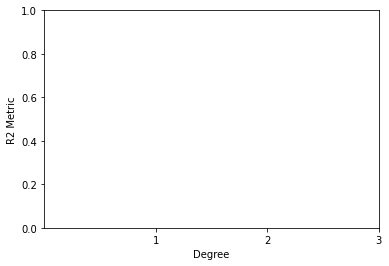

In [ ]:
#degree =[1,2]
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
#plt.xscale('log')
plt.xlabel("Degree" ,fontsize = 10 )
plt.ylabel("R2 Metric" ,fontsize = 10 )
plt.xticks(ticks = [1,2,3],fontsize = 10 ,fontweight= 500 )
plt.yticks(fontsize = 10,fontweight= 500) 
#ax = figure.add_subplot(111)
plt.plot(degree ,cvmodel.avgMetrics , '-o')
from google.colab import files
plt.savefig("Plain MLR.png")
files.download("Plain MLR.png")

#### Testing Plain MLR 

In [ ]:
pred = cvmodel.transform(df_test)

In [ ]:
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(pred,{eval.metricName:"r2"})

In [ ]:
r2

0.9500291853270415

### Lasso Regression 

In [ ]:
from pyspark.ml.regression import LinearRegression
# elasticnetparam = 0 --> ridge regression (L2 penalty )
lr =LinearRegression( featuresCol='poly_features_scaled', labelCol='sum(energy)',elasticNetParam=1)

In [ ]:
pipeline = Pipeline(stages = [lr])

In [ ]:
pipeline.write().overwrite().save("pipeline")
pipelineModel = Pipeline.load("pipeline")

In [ ]:
# elasticNetParam = Param(parent='undefined', name='elasticNetParam', 
#doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, 
#the penalty is an L2 penalty (ridge). For alpha = 1, it is an L1 penalty. (lasso)')
from pyspark.ml.tuning import ParamGridBuilder
paramGrid =  ParamGridBuilder().addGrid(lr.regParam, [1,0.1,0.01,0.001,0.0001,0.00001]).build()
#paramGrid =  ParamGridBuilder().build()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='sum(energy)', metricName='r2')

In [ ]:
alpha_lim = (0.00001,1)
boundaries = [alpha_lim]
extra_variables = (df_train['poly_features_scaled'],df_train['sum(energy)'])
# Set up Differential Evolution solver
solver = differential_evolution(obj_fun,boundaries,args=extra_variables,strategy='best1bin',
                                    popsize=15,mutation=0.5,recombination=0.7,tol=0.01,seed=2020)

NameError: ignored

In [ ]:
def obj_fun(x,X,y):
  print("I am here in obj function")
  #print(hyperparams)
  #alpha_value = [0.0001,0.001,.01,.1,1]
  alpha_value = x
  crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=ParamGridBuilder().addGrid(lr.regParam, alpha_value).build(),
                          evaluator=evaluator,numFolds=2,collectSubModels=True)
   
  cvmodel = crossval.fit(df_train)
  return cvmodel.avgMetrics
# Set limits for Differential Evolution
print("start of cell")
alpha_lim = (0.00001,1)
boundaries = [alpha_lim]
extra_variables = (df_train['poly_features_scaled'],df_train['sum(energy)'])
# Set up Differential Evolution solver
solver = differential_evolution(obj_fun,boundaries,args=extra_variables,strategy='best1bin',
                                    popsize=15,mutation=0.5,recombination=0.7,tol=0.01,seed=202,disp=True)

start of cell
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function
I am here in obj function


ValueError: ignored

In [ ]:
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4 ,collectSubModels=True)

In [ ]:
cvmodel = crossval.fit(df_train)

In [ ]:
cvmodel.avgMetrics

[0.8053398168428803,
 0.9310025851111892,
 0.948639381631783,
 0.9496571538197317,
 0.949375771696737,
 0.9492776032555462]

In [ ]:
alphas = [1,0.1,0.01,0.001,0.0001,0.00001]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

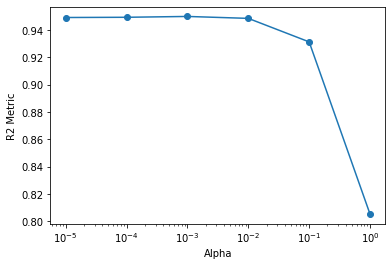

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
plt.xscale('log')
plt.xlabel("Alpha" ,fontsize = 10 )
plt.ylabel("R2 Metric" ,fontsize = 10 )
plt.xticks(fontsize = 10 ,fontweight= 500 )
plt.yticks(fontsize = 10,fontweight= 500) 
#ax = figure.add_subplot(111)
plt.plot(alphas ,cvmodel.avgMetrics , '-o')
from google.colab import files
plt.savefig("Lasso.png")
files.download("Lasso.png")

#### Testing Lasso Model 

In [ ]:
pred = cvmodel.transform(df_test)

In [ ]:
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(pred,{eval.metricName:"r2"})
r2

0.9486347791619845

### Ridge Regression 

In [ ]:
from pyspark.ml.regression import LinearRegression
# elasticnetparam = 0 --> ridge regression (L2 penalty )
lr =LinearRegression( featuresCol='poly_features_scaled', labelCol='sum(energy)',elasticNetParam=0.0)

In [ ]:
pipeline = Pipeline(stages = [lr])

In [ ]:
pipeline.write().overwrite().save("pipeline")
pipelineModel = Pipeline.load("pipeline")

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='sum(energy)', metricName='r2')

In [ ]:
# elasticNetParam = Param(parent='undefined', name='elasticNetParam', 
#doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, 
#the penalty is an L2 penalty (ridge). For alpha = 1, it is an L1 penalty. (lasso)')
from pyspark.ml.tuning import ParamGridBuilder
paramGrid =  ParamGridBuilder().addGrid(poly.degree,[2]).addGrid(lr.regParam, [1,0.1,0.01,0.001,0.0001,0.00001]).build()

In [ ]:
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2 ,collectSubModels=True)

In [ ]:
## fit model 
cvmodel = crossval.fit(df_train)

In [ ]:
type(cvmodel)

pyspark.ml.tuning.CrossValidatorModel

In [ ]:
best_model = cvmodel.bestModel

In [ ]:
best_model.stages[0].coefficients

DenseVector([0.0841, 0.0841, 0.1176, 0.0, 0.1176, 0.1188, 0.0, 0.0, 0.1188, 0.092, 0.0, 0.0, 0.0, 0.092, 0.0078, 0.0, 0.0, 0.0, 0.0, 0.0078, -0.0257, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0257, -0.1832, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1832, -0.2951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2951, -0.5871, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5871, -0.1321, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1321, -0.093, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.093, -0.0271, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0271, -0.1818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1818, -0.1185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1185, -0.149, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.149, -0.3074, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3074, -0.3717, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3717, -0.4549, 0.0, 0.0

In [ ]:
cvmodel.avgMetrics

[0.9285585312029696,
 0.9473718181120689,
 0.9505694744845054,
 0.9507604696721048,
 0.9507538815446994,
 0.9507524744392981]

In [ ]:
alphas = [1,0.1,0.01,0.001,0.0001,0.00001]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

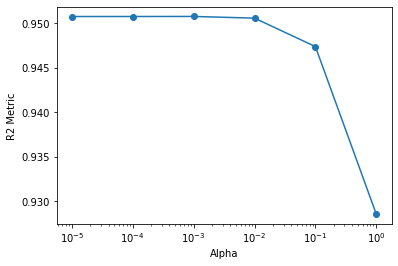

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
plt.xscale('log')
plt.xlabel("Alpha" ,fontsize = 10 )
plt.ylabel("R2 Metric" ,fontsize = 10 )
plt.xticks(fontsize = 10 ,fontweight= 500 )
plt.yticks(fontsize = 10,fontweight= 500) 
#ax = figure.add_subplot(111)
plt.plot(alphas ,cvmodel.avgMetrics , '-o')
from google.colab import files
plt.savefig("ridge.png")
files.download("ridge.png") 

In [ ]:
print(cvmodel.getEstimatorParamMaps()[np.argmax(cvmodel.avgMetrics)])

{Param(parent='PolynomialExpansion_554bb670a99b', name='degree', doc='the polynomial degree to expand (>= 1)'): 2, Param(parent='LinearRegression_a828ef852362', name='regParam', doc='regularization parameter (>= 0).'): 0.001}


## Evaluating dToU for Low Tariff:  

In [ ]:
df_low_tariff = df_low_tariff.na.drop()

In [ ]:
df_low_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
| 9.243999872356653|   Low|2013-02-21 03:00:00|          45|        0|       1.29|    0.63|    3|       0|
|10.618000095710158|   Low|2013-09-13 13:00:00|          42|        1|      17.16|    0.92|   13|       0|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [ ]:
df_low_tariff.count()

NameError: ignored

In [ ]:
from pyspark.ml.feature import OneHotEncoder
stages = []
column_list = ['hour2' ,'week_end','day_night']
for column in column_list :
  encoder = OneHotEncoder(inputCol=column, outputCol=column+"_encoded")
  stages.append(encoder)
pipeline = Pipeline(stages = stages )
df_encoded_low_tariff = pipeline.fit(df_low_tariff).transform(df_low_tariff)  

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['hour2_encoded','temperature' ,'humidity','week_end_encoded','day_night_encoded','count(LCLid)'] 
                                   ,outputCol = 'features_vector')
df_encoded_low_tariff = vector_assembler.transform(df_encoded_low_tariff)
df_encoded_low_tariff.show(3)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
| 9.243999872356653|   Low|2013-02-21 03:00:00|          45|        0|       1.29|    0.63|    3|       0| (23,[3],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[3,23,24,25,2...|
|10.618000095710158|   Low|2013-09-13 13:00:00|          42|        1|      17.16|    0.92|   13|       0|(23,[13],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[13,23,24,25,...|
|12.554000040516257|   Low|2013-11-26 15:00:00|          44|        1|       7.23|    0.64|   15|       0

In [ ]:
from pyspark.ml import Pipeline
# expansion parameters 
from pyspark.ml.feature import PolynomialExpansion
poly = PolynomialExpansion(inputCol='features_vector', outputCol='poly_features')
df_encoded_low_tariff = poly.transform(df_encoded_low_tariff)

In [ ]:
ss = StandardScaler(withMean=True, withStd=True, inputCol='poly_features' , outputCol='poly_features_scaled')

In [ ]:
df_encoded_low_tariff = ss.fit(df_encoded_low_tariff).transform(df_encoded_low_tariff)

In [ ]:
df_encoded_low_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
| 9.243999872356653|   Low|2013-02-21 03:00:00|          45|        0|       1.29|    0.63|    3|       0| (23,[3],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[3,23,24,25,2...|(464,[9,13,299,30...|[-0.2220530081768...|
|10.618000095710158|   Low|2013-09-13 13:00:00|          42|        1|      17.16|    0.92|   13|       0|(23,[13],[

In [ ]:
predictions_low_block34 = cvmodel.transform(df_encoded_low_tariff)

In [ ]:
# r2 
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(predictions_low_block34,{eval.metricName:"r2"})
r2

-0.019261404109941038

In [ ]:
predictions_low_block34.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|        prediction|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+------------------+
| 9.243999872356653|   Low|2013-02-21 03:00:00|          45|        0|       1.29|    0.63|    3|       0| (23,[3],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[3,23,24,25,2...|(464,[9,13,299,30...|[-0.2220530081768...| 5.918123556878835|
|10.618000095710158|   Low|2013-09-13 13

In [ ]:
predictions_low_pandas_block34= predictions_low_block34.toPandas()

In [ ]:
predictions_low_pandas_block34.to_csv("/content/drive/MyDrive/predictions_low_block34.csv")



```
# This is formatted as code
```

## Evaluating dToU for High Tariff:  

In [ ]:
df_high_tariff = df_high_tariff.na.drop()

In [ ]:
df_high_tariff.count()

394

In [ ]:
df_high_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
| 8.450999953784049|  High|2013-06-17 11:00:00|          46|        1|      17.54|    0.61|   11|       0|
|17.120000015944242|  High|2013-12-15 20:00:00|          44|        2|      12.42|    0.91|   20|       1|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [ ]:
from pyspark.ml.feature import OneHotEncoder
stages = []
column_list = ['hour2' ,'week_end','day_night']
for column in column_list :
  encoder = OneHotEncoder(inputCol=column, outputCol=column+"_encoded")
  stages.append(encoder)
pipeline = Pipeline(stages = stages )
df_encoded_high_tariff = pipeline.fit(df_high_tariff).transform(df_high_tariff) 

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['hour2_encoded','temperature' ,'humidity','week_end_encoded','day_night_encoded','count(LCLid)'] 
                                   ,outputCol = 'features_vector')
df_encoded_high_tariff = vector_assembler.transform(df_encoded_high_tariff)
df_encoded_high_tariff.show(3)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
| 8.450999953784049|  High|2013-06-17 11:00:00|          46|        1|      17.54|    0.61|   11|       0|(23,[11],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[11,23,24,25,...|
|17.120000015944242|  High|2013-12-15 20:00:00|          44|        2|      12.42|    0.91|   20|       1|(23,[20],[1.0])|       (1,[],[])|        (2,[],[])|(29,[20,23,24,28]...|
|18.276000071316957|  High|2013-12-27 22:00:00|          44|        2|       7.47|    0.73|   22|       0

In [ ]:
from pyspark.ml import Pipeline
# expansion parameters 
from pyspark.ml.feature import PolynomialExpansion
poly = PolynomialExpansion(inputCol='features_vector', outputCol='poly_features')
df_encoded_high_tariff = poly.transform(df_encoded_high_tariff)

In [ ]:
ss = StandardScaler(withMean=True, withStd=True, inputCol='poly_features' , outputCol='poly_features_scaled')

In [ ]:
df_encoded_high_tariff = ss.fit(df_encoded_high_tariff).transform(df_encoded_high_tariff)

In [ ]:
df_encoded_high_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
| 8.450999953784049|  High|2013-06-17 11:00:00|          46|        1|      17.54|    0.61|   11|       0|(23,[11],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[11,23,24,25,...|(464,[77,89,299,3...|[-0.1527000060419...|
|17.120000015944242|  High|2013-12-15 20:00:00|          44|        2|      12.42|    0.91|   20|       1|(23,[20],[

In [ ]:
predictions_high_block34 = cvmodel.transform(df_encoded_high_tariff)

In [ ]:
# r2 
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(predictions_high_block34,{eval.metricName:"r2"})
r2

-0.03638424251754535

In [ ]:
predictions_high_pandas_block34= predictions_high_block34.toPandas()

In [ ]:
predictions_high_pandas_block34.to_csv("/content/drive/MyDrive/predictions_high_block34.csv")